# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***Specific Emotions***

In [1]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind, chisquare, chi2_contingency, chi2

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix

# visualization tools
import matplotlib.pyplot as plt, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")

# only get warnings once
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%run Acetaminophen_Functions.ipynb

 # **Post Hoc: Are Emotion Terms Used Differently**
The last goal of this analysis is to test whether those who ingested acetaminophen and those who took a placebo believe the same emotions apply to the stimuli.

**Recall that participants were asked to answer the following questions about the specific emotions:**
* Identify which emotion(s) the audio file [*represents* or *makes you feel*] by checking the appropriate emotion(s) from the following list. You may select as few or as many as you like
* Given this list of emotion terms you chose, which one(s), if any, strongly apply?

In [2]:
emotions = pd.read_csv('emotions.csv')
emotions_p = emotions[emotions['Locus']=="Perceived"]
emotions_i = emotions[emotions['Locus']=="Induced"]

In [3]:
negative_high = ['Anger', 'Anxious', 'Fearful', 'Grieved', 'Tension']
negative_low = ['Bored','Disgusted','Sad']
positive_low = ['Nostalgic','Peaceful','Relaxed','Softhearted','Sympathetic','Tender']
positive_high = ['Excited','Happy','Invigorated','Joyful','Power','Transcendent','Wonder']
    # note -- I didn't use Surprised or Neutral here because I wasn't sure what the valence would be

emotion_types = negative_high + negative_low + positive_low + positive_high + ['Surprised','Neutral']

# binary
binary_emotions = emotions.copy()
binary_emotions[emotion_types] = binary_emotions[emotion_types].replace({2.0:1.0})

In [4]:
# Make arrays for graphs
perceived = binary_emotions[binary_emotions['Locus']=="Perceived"]
induced = binary_emotions[binary_emotions['Locus']=="Induced"]

# Perceived

In [5]:
cols = list(perceived.loc[:, 'Anger':'Neutral'].columns)
notstudied = pd.DataFrame(perceived.isnull().mean()*100)
notstudied = notstudied[notstudied[0] > 0]
delete = list(notstudied.index)
perceived = perceived.drop(columns = list(notstudied.index)).reset_index(drop=True)

placebo = perceived[perceived['DrugPlacebo']=="Placebo"]
drug = perceived[perceived['DrugPlacebo']=="Drug"]

In [6]:
### SUMS ###
# only use binary coding here
num_stim_obs_dict = {"Drug":perceived[perceived.DrugPlacebo == "Drug"]['DrugPlacebo'].count(),
                     "Placebo":perceived[perceived.DrugPlacebo == "Placebo"]['DrugPlacebo'].count()
                    }

emo_sums = pd.DataFrame()

p_emotion_types = ['Bored','Disgusted', 'Excited', 'Fearful', 'Grieved', 'Happy', 'Invigorated',
                   'Relaxed', 'Sad', 'Surprised', 'Tender', 'Neutral']

# no anger bc it is 0
for k,v in num_stim_obs_dict.items():
    emo_sums[k] = perceived.loc[perceived['DrugPlacebo']==k,p_emotion_types].sum()
emo_sums = emo_sums.T

# are the general distributions different?
chisq, p, dof, expected = chi2_contingency(emo_sums)
print("chi-sq. = " + str(chisq.round(3)))
print("p = " + str(p.round(3)))
print("degrees of freedom = " + str(dof), "\n")

chi-sq. = 16.45
p = 0.125
degrees of freedom = 11 



In [7]:
emo_sums

,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Relaxed,Sad,Surprised,Tender,Neutral
Drug,207.0,208.0,911.0,909.0,410.0,1032.0,434.0,775.0,723.0,611.0,359.0,606.0
Placebo,250.0,154.0,858.0,851.0,365.0,1000.0,376.0,736.0,637.0,575.0,348.0,586.0


#### *Percents*
Examine the percent of time the emotion term applipercent of time the emotion term applies or strongly applieses or strongly applies to the stimuli.

In [28]:
### 3-point scale coding
emo_app = pd.DataFrame({"DrugPlacebo":['Placebo','Drug']}, columns=['DrugPlacebo']+p_emotion_types).set_index('DrugPlacebo')
emo_st = pd.DataFrame({"DrugPlacebo":['Placebo','Drug']}, columns=['DrugPlacebo']+p_emotion_types).set_index('DrugPlacebo')

for col in p_emotion_types:
    emo_app.loc['Placebo',col] = round((emotions_p[emotions_p['DrugPlacebo']=="Placebo"][col]==1.0).sum()/len(emotions_p[emotions_p['DrugPlacebo']=="Placebo"]),5)*100
    emo_app.loc['Drug',col] = round((emotions_p[emotions_p['DrugPlacebo']=="Drug"][col]==1.0).sum()/len(emotions_p[emotions_p['DrugPlacebo']=="Drug"]),5)*100
    emo_st.loc['Placebo',col] = round((emotions_p[emotions_p['DrugPlacebo']=="Placebo"][col]==2.0).sum()/len(emotions_p[emotions_p['DrugPlacebo']=="Placebo"]),5)*100
    emo_st.loc['Drug',col] = round((emotions_p[emotions_p['DrugPlacebo']=="Drug"][col]==2.0).sum()/len(emotions_p[emotions_p['DrugPlacebo']=="Drug"]),5)*100

emo_app.columns=[s+'_Applies' for s in p_emotion_types]
emo_st.columns=[s+'_Strongly_Applies' for s in p_emotion_types]
emo_perc_012 = emo_app.merge(emo_st, left_index=True, right_index=True)
emo_perc_012 = emo_perc_012.reindex(sorted(emo_perc_012.columns), axis=1)
emo_perc_012.reset_index(drop=False, inplace=True)

In [29]:
p_emo_app = emo_app.T
p_emo_app.rename(columns={'Placebo':'Placebo Applies', 'Drug':'Drug Applies'}, inplace=True)
p_emo_app.index = p_emo_app.index.str.split('_').str[0]


p_emo_st = emo_st.T
p_emo_st.rename(columns={'Placebo':'Placebo St. Applies', 'Drug':'Drug St. Applies'}, inplace=True)
p_emo_st.index = p_emo_st.index.str.split('_').str[0]
p_emo_st

p_df = p_emo_app.merge(p_emo_st, left_index=True, right_index=True)
p_df[['Placebo Applies', 'Placebo St. Applies', 'Drug Applies', 'Drug St. Applies']].round(3)

DrugPlacebo,Placebo Applies,Placebo St. Applies,Drug Applies,Drug St. Applies
Bored,2.93,2.748,2.502,2.122
Disgusted,2.339,1.158,3.015,1.631
Excited,8.971,10.516,8.979,11.369
Fearful,7.518,11.81,8.309,11.995
Grieved,4.156,4.134,5.026,4.132
Happy,12.06,10.652,12.352,10.699
Invigorated,5.292,3.248,6.321,3.373
Relaxed,6.836,9.88,7.215,10.096
Sad,6.268,8.199,7.393,8.756
Surprised,7.381,5.678,8.287,5.361


In [9]:
# strongly applies
st_app_cols = ['DrugPlacebo'] + [c for c in emo_perc_012.columns if '_Strongly_' in c] 
st_app = emo_perc_012[st_app_cols]

st_app.columns = [c.split('_')[0] for c in st_app.columns]
app_column = "Strongly Applies"
st_app.insert(1, 'Apply', app_column)

# applies
app_cols = [c for c in emo_perc_012.columns if '_Strongly_' not in c] 
app = emo_perc_012[app_cols]

app.columns = [c.split('_')[0] for c in app.columns]
app_column = "Applies"
app.insert(1, 'Apply', app_column)

stacked = app.append(st_app, ignore_index=True)
stacked_emo_perc_012 = pd.melt(stacked, id_vars=['DrugPlacebo', 'Apply'], value_vars=p_emotion_types)

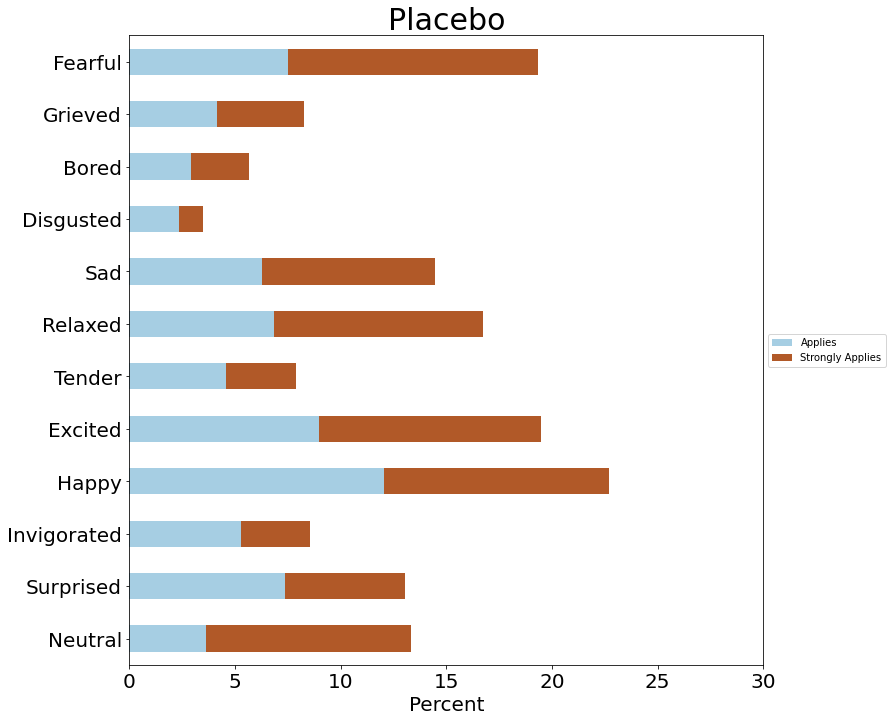

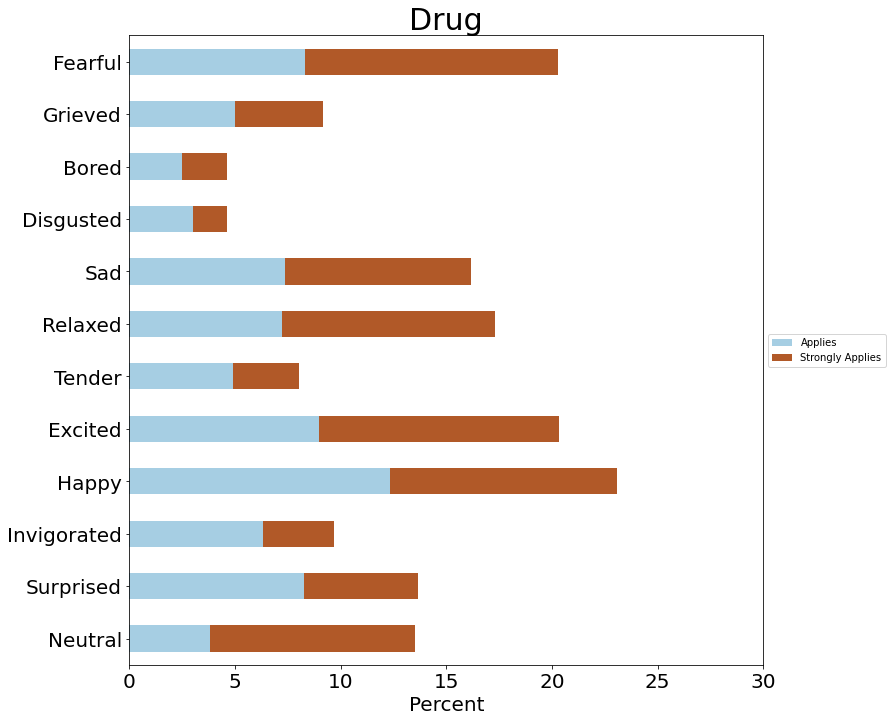

In [10]:
stim_list = stacked_emo_perc_012.DrugPlacebo.unique().tolist()
order_list = ['Fearful', 'Grieved', 
              'Bored', 'Disgusted', 'Sad', 
              'Relaxed', 'Tender',
              'Excited', 'Happy', 'Invigorated',
              'Surprised', 'Neutral']
order_list.reverse()
mapping = {emotion: i for i, emotion in enumerate(order_list)}

for i, stim in enumerate(stim_list):
    df_plot = stacked[stacked.DrugPlacebo == stim].T
    df_plot.columns = df_plot.loc['Apply']
    key = df_plot.index.map(mapping)
    df_plot = df_plot.iloc[key.argsort()]
    df_plot.drop(labels = ['DrugPlacebo', 'Apply'], inplace=True)
    
    df_plot.plot.barh(stacked=True, figsize=(10,10), colormap='Paired'); #, colormap='gray'
    plt.gray()
    plt.title(stim, size = 30)
    plt.ylabel('')
    plt.xlabel('Percent',fontsize=20)
    plt.tight_layout()
    #plt.legend(title=None, loc='lower right', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=False, ncol=2, mode="expand")
    plt.legend(title=None,loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False) #(title=None
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(0,30)

(0.0, 30.0)

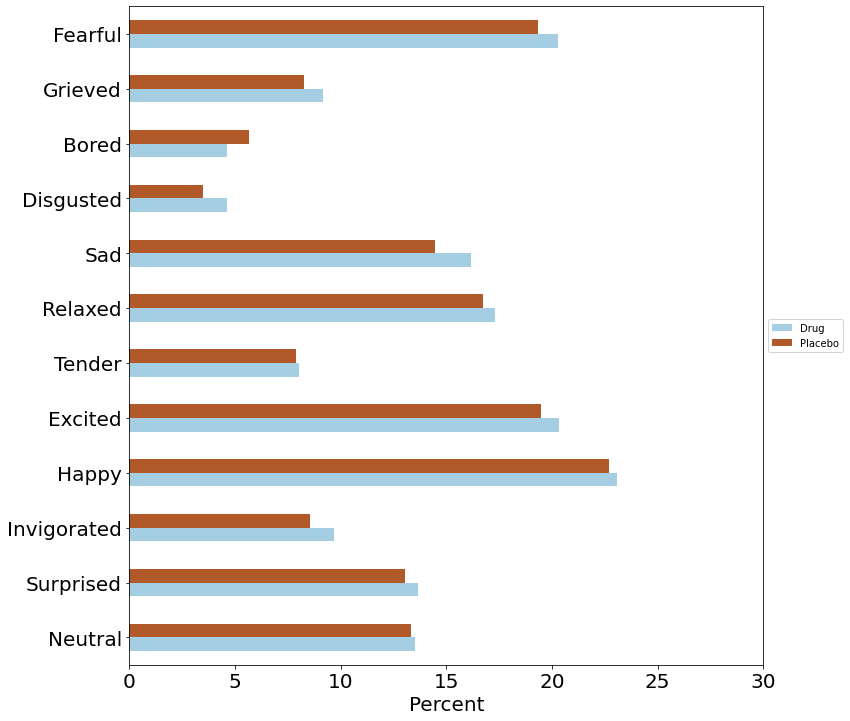

In [43]:
p_df['Drug'] = p_df['Drug Applies'] + p_df['Drug St. Applies']
p_df['Placebo'] = p_df['Placebo Applies'] + p_df['Placebo St. Applies']
df_plot = p_df[['Drug','Placebo']] 
#df_plot = stacked.loc[stacked.Apply == "Applies"].T
#df_plot.columns = df_plot.loc['DrugPlacebo']
key = df_plot.index.map(mapping)
df_plot = df_plot.iloc[key.argsort()]
# df_plot.drop(labels = ['DrugPlacebo', 'Apply'], inplace=True)

df_plot.plot.barh(stacked=False, figsize=(10,10), colormap='Paired'); #, colormap='gray'
plt.gray()
plt.ylabel('')
plt.xlabel('Percent',fontsize=20)
plt.tight_layout()
plt.legend(title=None,loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False) #(title=None
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,30)

# Induced

In [12]:
cols = list(induced.loc[:, 'Anger':'Neutral'].columns)
placebo = induced[induced['DrugPlacebo']=="Placebo"]
drug = induced[induced['DrugPlacebo']=="Drug"]

In [13]:
### SUMS ###
# only use binary coding here
emo_sums = pd.DataFrame()

#no anger bc it is 0
i_emotion_types = [e for e in emotion_types if e is not 'Anger']
for k,v in num_stim_obs_dict.items():
    emo_sums[k] = induced.loc[induced['DrugPlacebo']==k,i_emotion_types].sum()
emo_sums = emo_sums.T

# are the general distributions different?
chisq, p, dof, expected = chi2_contingency(emo_sums)
print("chi-sq. = " + str(chisq.round(3)))
print("p = " + str(p.round(3)))
print("degrees of freedom = " + str(dof), "\n")

chi-sq. = 21.061
p = 0.455
degrees of freedom = 21 



In [14]:
### 3-point scale coding
emo_app = pd.DataFrame({"DrugPlacebo":['Placebo','Drug']}, columns=['DrugPlacebo']+i_emotion_types).set_index('DrugPlacebo')
emo_st = pd.DataFrame({"DrugPlacebo":['Placebo','Drug']}, columns=['DrugPlacebo']+i_emotion_types).set_index('DrugPlacebo')

for col in i_emotion_types:
    emo_app.loc['Placebo',col] = round((emotions_i[emotions_i['DrugPlacebo']=="Placebo"][col]==1.0).sum()/len(emotions_i[emotions_i['DrugPlacebo']=="Placebo"]),5)*100
    emo_app.loc['Drug',col] = round((emotions_i[emotions_i['DrugPlacebo']=="Drug"][col]==1.0).sum()/len(emotions_i[emotions_i['DrugPlacebo']=="Drug"]),5)*100
    emo_st.loc['Placebo',col] = round((emotions_i[emotions_i['DrugPlacebo']=="Placebo"][col]==2.0).sum()/len(emotions_i[emotions_i['DrugPlacebo']=="Placebo"]),5)*100
    emo_st.loc['Drug',col] = round((emotions_i[emotions_i['DrugPlacebo']=="Drug"][col]==2.0).sum()/len(emotions_i[emotions_i['DrugPlacebo']=="Drug"]),5)*100

emo_app.columns=[s+'_Applies' for s in i_emotion_types]
emo_st.columns=[s+'_Strongly_Applies' for s in i_emotion_types]
emo_perc_012 = emo_app.merge(emo_st, left_index=True, right_index=True)
emo_perc_012 = emo_perc_012.reindex(sorted(emo_perc_012.columns), axis=1)
emo_perc_012.reset_index(drop=False, inplace=True)

In [15]:
# strongly applies
st_app_cols = ['DrugPlacebo'] + [c for c in emo_perc_012.columns if '_Strongly_' in c] 
st_app = emo_perc_012[st_app_cols]

st_app.columns = [c.split('_')[0] for c in st_app.columns]
app_column = "Strongly Applies"
st_app.insert(1, 'Apply', app_column)

# applies
app_cols = [c for c in emo_perc_012.columns if '_Strongly_' not in c] 
app = emo_perc_012[app_cols]

app.columns = [c.split('_')[0] for c in app.columns]
app_column = "Applies"
app.insert(1, 'Apply', app_column)

stacked = app.append(st_app, ignore_index=True)
stacked_emo_perc_012 = pd.melt(stacked, id_vars=['DrugPlacebo', 'Apply'], value_vars=i_emotion_types)

In [16]:
i_emo_app = emo_app.T
i_emo_app.rename(columns={'Placebo':'Placebo Applies', 'Drug':'Drug Applies'}, inplace=True)
i_emo_app.index = i_emo_app.index.str.split('_').str[0]


i_emo_st = emo_st.T
i_emo_st.rename(columns={'Placebo':'Placebo St. Applies', 'Drug':'Drug St. Applies'}, inplace=True)
i_emo_st.index = i_emo_st.index.str.split('_').str[0]
i_emo_st

i_df = i_emo_app.merge(i_emo_st, left_index=True, right_index=True)
i_df[['Placebo Applies', 'Placebo St. Applies', 'Drug Applies', 'Drug St. Applies']].round(3)

DrugPlacebo,Placebo Applies,Placebo St. Applies,Drug Applies,Drug St. Applies
Anxious,10.458,9.711,12.022,12.432
Fearful,9.244,9.057,8.652,9.244
Grieved,4.155,2.101,4.599,2.732
Tension,8.964,7.33,10.883,6.967
Bored,2.568,1.867,2.049,1.776
Disgusted,2.521,1.634,3.188,1.138
Sad,6.583,5.415,7.013,6.421
Nostalgic,6.676,5.602,6.239,5.464
Peaceful,5.322,5.882,7.787,5.92
Relaxed,6.909,4.902,8.06,6.102


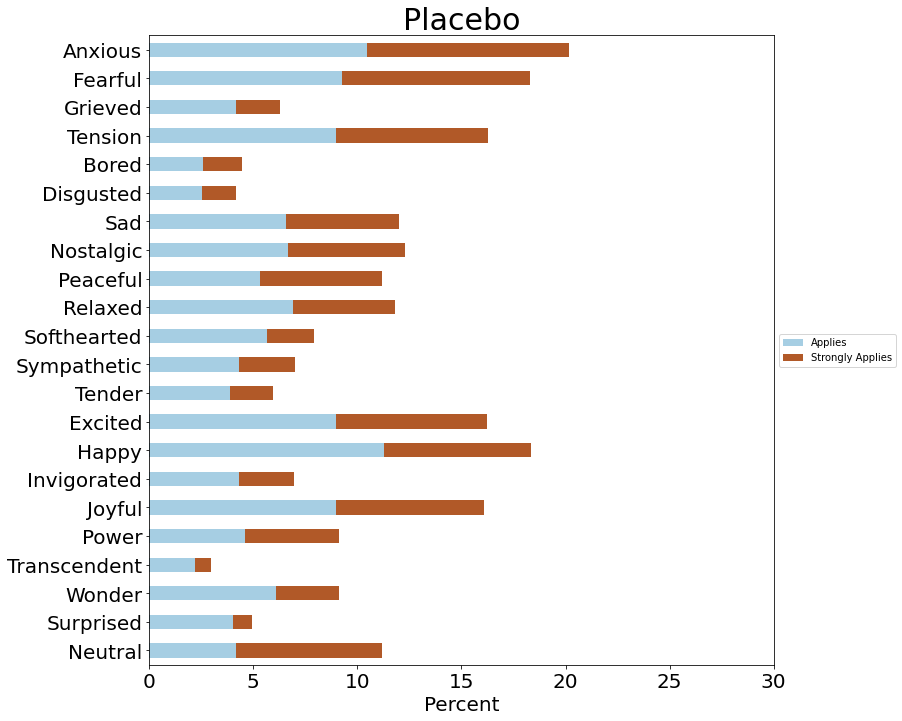

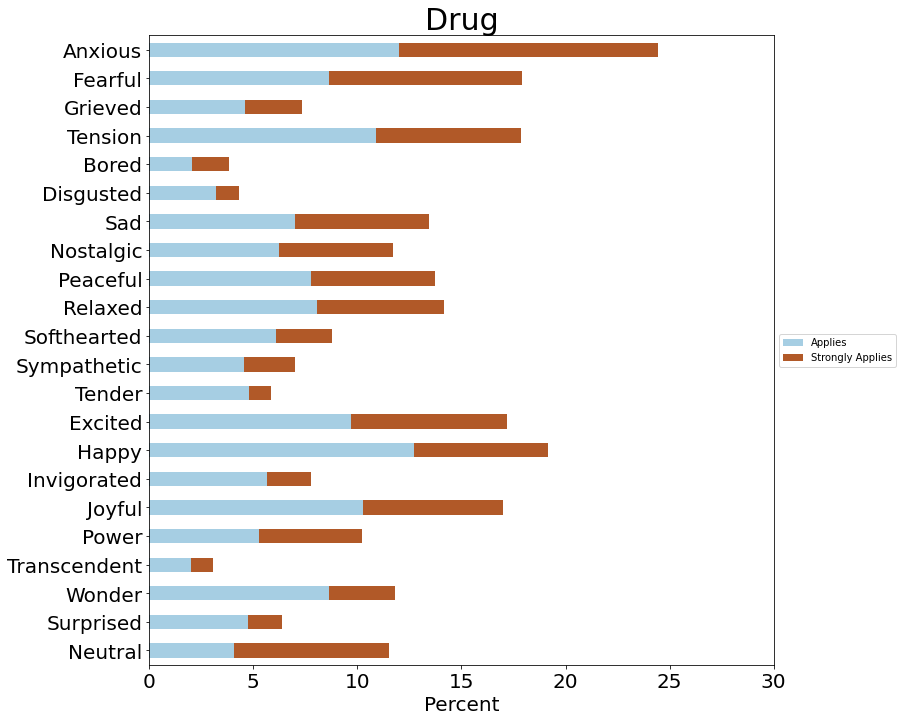

In [17]:
stim_list = stacked_emo_perc_012.DrugPlacebo.unique().tolist()
order_list = i_emotion_types
order_list.reverse()
mapping = {emotion: i for i, emotion in enumerate(order_list)}

for i, stim in enumerate(stim_list):
    df_plot = stacked[stacked.DrugPlacebo == stim].T
    df_plot.columns = df_plot.loc['Apply']
    key = df_plot.index.map(mapping)
    df_plot = df_plot.iloc[key.argsort()]
    df_plot.drop(labels = ['DrugPlacebo', 'Apply'], inplace=True)
    
    df_plot.plot.barh(stacked=True, figsize=(10,10), colormap='Paired'); 
    plt.gray()
    plt.title(stim, size = 30)
    plt.ylabel('')
    plt.xlabel('Percent',fontsize=20)
    plt.tight_layout()
    plt.legend(title=None,loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False) #(title=None
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(0,30)

(0.0, 30.0)

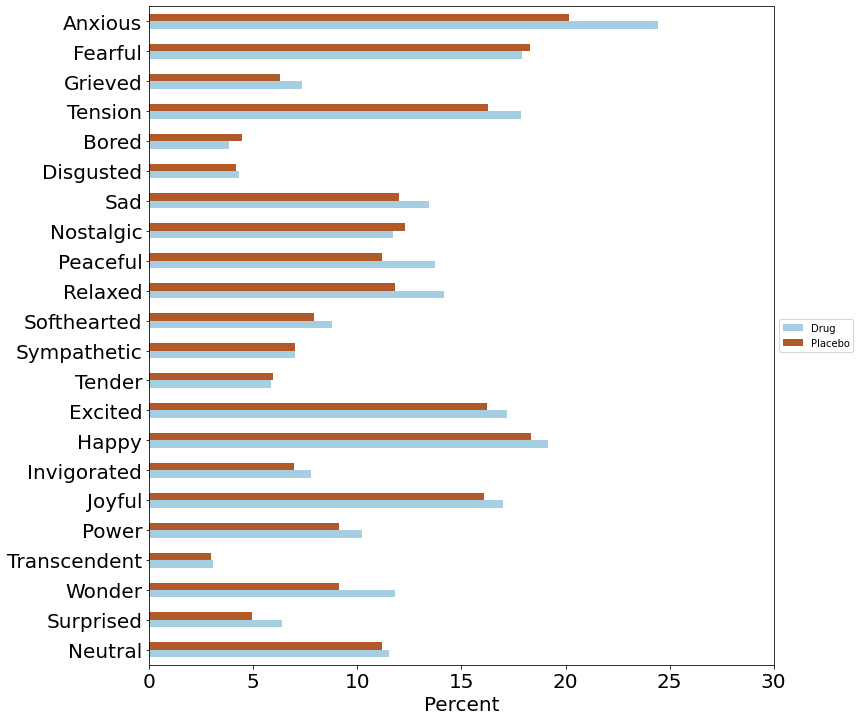

In [44]:
i_df['Drug'] = i_df['Drug Applies'] + i_df['Drug St. Applies']
i_df['Placebo'] = i_df['Placebo Applies'] + i_df['Placebo St. Applies']
df_plot = i_df[['Drug','Placebo']] 
key = df_plot.index.map(mapping)
df_plot = df_plot.iloc[key.argsort()]

df_plot.plot.barh(stacked=False, figsize=(10,10), colormap='Paired'); #, colormap='gray'
plt.gray()
plt.ylabel('')
plt.xlabel('Percent',fontsize=20)
plt.tight_layout()
plt.legend(title=None,loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False) #(title=None
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,30)

# Scratchpad

In [19]:
# cols = list(induced.loc[:, 'Anger':'Neutral'].columns)

# percentAppliesI = pd.DataFrame()
# for column in cols:
#     percentAppliesI.loc[column, 'Drug'] = 100 - (len(drug[column].loc[drug[column] == 0])/len(drug)*100)
#     percentAppliesI.loc[column, 'Placebo'] = 100 - (len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100)
# percentAppliesI.T

In [20]:
# # make placebo summary table
# placeboSummary = pd.DataFrame()
# placeboSummary['Sum'] = placebo[cols].sum()
# placeboSummary['Mean'] = placebo[cols].mean()
# placeboSummary['SD'] = placebo[cols].std()

# for column in cols:
#     placeboSummary.loc[column, 'Does Not Apply'] = len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100
#     placeboSummary.loc[column, 'Applies'] = len(placebo[column].loc[placebo[column] == 1])/len(placebo)*100
#     placeboSummary.loc[column, 'Strongly Applies'] = len(placebo[column].loc[placebo[column] == 2])/len(placebo)*100

# placeboSummary['DrugPlacebo'] = "Placebo"
# placeboSummary['Emotion'] = placeboSummary.index

# # make drug summary table
# drugSummary = pd.DataFrame()
# drugSummary['Sum'] = drug[cols].sum()
# drugSummary['Mean'] = drug[cols].mean()
# drugSummary['SD'] = drug[cols].std()

# for column in cols:
#     drugSummary.loc[column, 'Does Not Apply'] = len(drug[column].loc[drug[column] == 0])/len(drug)*100
#     drugSummary.loc[column, 'Applies'] = len(drug[column].loc[drug[column] == 1])/len(drug)*100
#     drugSummary.loc[column, 'Strongly Applies'] = len(drug[column].loc[drug[column] == 2])/len(drug)*100

# drugSummary['DrugPlacebo'] = "Drug"
# drugSummary['Emotion'] = drugSummary.index

# # rbind
# inducedSummary = pd.concat([placeboSummary, drugSummary])
# print("inducedSummary shape:", inducedSummary.shape)
# print(drugSummary.shape[0] + placeboSummary.shape[0])

# #  transform to long format
# inducedLong = pd.melt(inducedSummary, id_vars=['Emotion', 'DrugPlacebo', 'Mean', 'SD'], 
#                       value_vars=['Applies', 'Strongly Applies'])

# inducedLong.sample(5)

In [21]:
# colors = ["#3498db", "#9b59b6"]

# plt.figure(figsize=(30,25))
# for i, emotion in enumerate(list(inducedLong['Emotion'].unique())):
#     plt.subplot(6, 4, i+1)
#     sns.barplot(x="variable", y="value", hue="DrugPlacebo", data=inducedLong[inducedLong['Emotion'] == emotion], palette=colors)
#     plt.title(emotion, size = 22)
#     plt.xlabel('')
#     plt.ylabel('Percent of Responses', fontsize=16)
#     plt.tight_layout()
#     plt.ylim(0, 50)
#     plt.tick_params(axis='both', which='major', labelsize=12)
#     plt.legend(loc = 1, prop={'size': 12})
# plt.show()